In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import story_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num

In [ ]:
pilot_data_dir = "/home/chansingh/mntv1/deep-fMRI/story_data/20230504"
resp_np_files = os.listdir(pilot_data_dir)
resps_dict = {k: np.load(join(pilot_data_dir, k)) for k in tqdm(resp_np_files)}
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot_story_data.pkl'))

In [ ]:
# viz mean driving resp for each of the 16 voxels
resp_chunks_list = []
for story_num in range(6): # range(1, 7)
    rows = story_data["rows"][story_num]
    rw = rows[
        [
            "expl",
            "module_num",
            "top_explanation_init_strs",
            "subject",
            "fmri_test_corr",
            "top_score_synthetic",
            "roi_anat",
            "roi_func",
        ]
    ]
    rw["voxel_num"] = rw.apply(
        lambda row: convert_module_num_to_voxel_num(row["module_num"], row["subject"]),
        axis=1,
    )
    voxel_nums = rw["voxel_num"].values
    paragraphs = story_data["story_text"][story_num].split("\n\n")
    assert len(paragraphs) == len(rw), (len(paragraphs), len(rw))
    timing = story_data["timing"][story_num]

    resp_story = resps_dict[story_data["story_name_new"][story_num]].T  # (voxels, time)
    resp_chunks = story_helper.get_resp_chunks(timing, paragraphs, resp_story, apply_offset=False)

    args = np.argsort(rw["expl"].values)
    resp_chunks_list.append([resp_chunks[i][voxel_nums] for i in args])

# resp_chunks_arr = np.array(resp_chunks_list).mean(axis=0)
expls = rw.sort_values(by="expl")["expl"].values

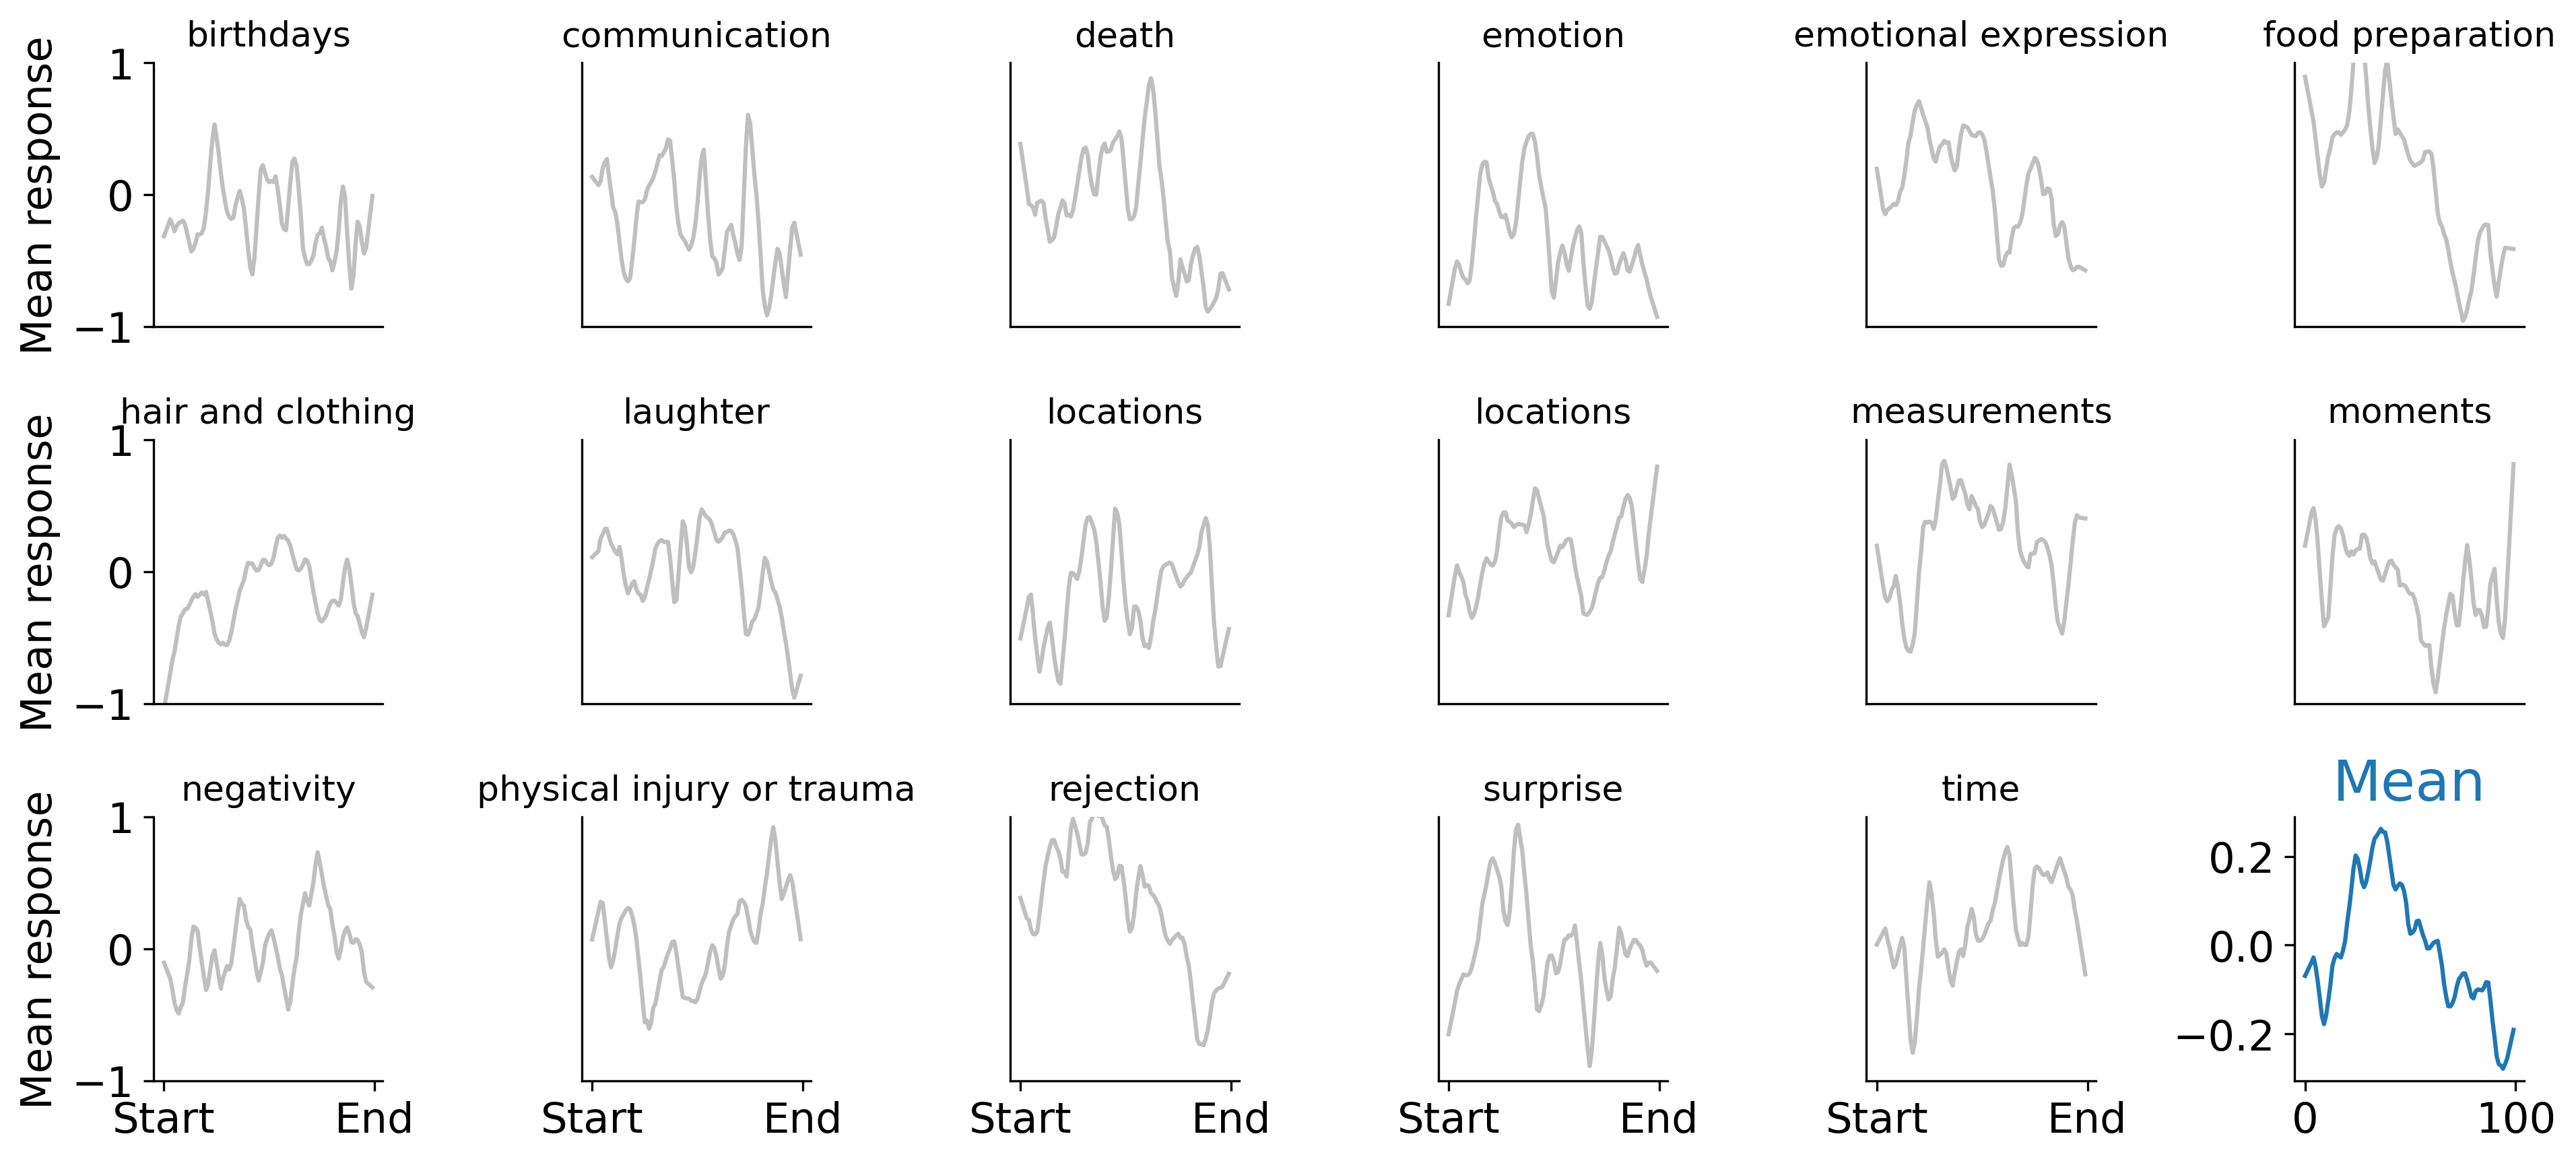

In [60]:
# resp_chunks_list (n_stories, n_voxels (driving), n_voxels (resp), n_time)
n_voxels = len(resp_chunks_list[0])
n_stories = len(resp_chunks_list)
plt.figure(figsize=(13, 6), dpi=300)
resps_rep_means = []
C = 6
R = 3
for voxel_num in range(n_voxels):
    plt.subplot(R, C, voxel_num + 1)  
    resps_rep = []
    for story_num in range(n_stories):
        # print(resp_chunks_list[story_num][voxel_num]) 
        resps_rep.append(resp_chunks_list[story_num][voxel_num][voxel_num])
    
    # interpolate each story to 100 time points
    resps_rep_interp = []
    for resp_rep in resps_rep:
        resps_rep_interp.append(
            np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(resp_rep)),
                      resp_rep))
    resps_rep_interp = np.array(resps_rep_interp)
    resps_rep_mean = resps_rep_interp.mean(axis=0)
    # print('shape', resps_rep_mean.shape)
    plt.plot(resps_rep_mean, color='gray', alpha=0.5)
    plt.ylim(-1, 1)
    if voxel_num % C != 0:
        plt.yticks([])
    else:
        plt.ylabel('Mean response')
    if voxel_num < C * (R - 1):
        plt.xticks([])
    else:
        plt.xticks([0, 100], ['Start', 'End'])
    resps_rep_means.append(resps_rep_mean)
    plt.title(expls[voxel_num], fontsize='small')


plt.subplot(R, C, voxel_num + 2)  
plt.title('Mean', color='C0')
plt.plot(np.array(resps_rep_means).mean(axis=0), color='C0')
plt.tight_layout()